# Pr.8 Определение региона добычи, где разработка нефтяных скважин принесет наибольшую прибыль

## Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
#from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

#from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
#from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor

from numpy.random import RandomState

import warnings
warnings.filterwarnings("ignore")  # игнорирование всех предупреждений
#warnings.simplefilter(action='ignore', category=FutureWarning)  # игнорирование будущих предупреждений

In [2]:
path='https://code.s3.yandex.net/datasets/'

file_name='geo_data_0.csv'
df_0 = pd.read_csv(path+file_name) #,sep='\t')

file_name='geo_data_1.csv'
df_1 = pd.read_csv(path+file_name) 

file_name='geo_data_2.csv'
df_2 = pd.read_csv(path+file_name) 

In [3]:
df_0.info()
df_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df_1.info()
df_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
df_2.info()
df_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
df_0.duplicated().sum()

0

In [7]:
df_1.duplicated().sum()

0

In [8]:
df_2.duplicated().sum()

0

In [9]:
df_0.columns

Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

In [10]:
df_1.columns

Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

In [11]:
df_2.columns

Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

Пропусков и полных дубликатов нет. Названия столбцов корректны (без пробелов). 

In [12]:
df_0['id'].value_counts()

QcMuo    2
HZww2    2
A5aEY    2
TtcGQ    2
bsk9y    2
        ..
dWq3j    1
DVAXH    1
2TlJc    1
EutN1    1
Oag5x    1
Name: id, Length: 99990, dtype: int64

In [13]:
df_0['id'].value_counts()[df_0['id'].value_counts() > 1]

QcMuo    2
HZww2    2
A5aEY    2
TtcGQ    2
bsk9y    2
bxg6G    2
74z30    2
fiKDv    2
AGS9W    2
Tdehs    2
Name: id, dtype: int64

In [14]:
df_1['id'].value_counts()[df_1['id'].value_counts() > 1]

bfPNe    2
wt4Uk    2
LHZR0    2
5ltQ6    2
Name: id, dtype: int64

In [15]:
df_2['id'].value_counts()[df_2['id'].value_counts() > 1]

KUPhW    2
Vcm5J    2
VF7Jo    2
xCHr8    2
Name: id, dtype: int64

In [16]:
df_2[df_2['id'] == 'KUPhW']

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


Обнаружены для одних и тех же скаважин разные наборы признаков и целевой переменной: 10 повторов для датасета df_0  и по 4 повтора для латасатов df_1 и df_2. Это могут быть либо ошибочные данные, либо можно считать, что из одной и той же скважины в разное время делалось по 2 измерения. Поскольку уточнить этот момент мы не имеем возможности, а также в силу незначительности количества таких данных (10 / 100000 = 0,01%, 4 / 100000 = 0,004%, т.е. всего 0,01% и 0,004% от всего объема наблюдений в датасетах), нам подходит любой вариант. Пойдем по второму варианту (повторные замеры в скважинах) и оставим эти данные.

На этапе построения и обучения моделей лучше избавляться от ненужных признаков, коими являются 'id' скаважин. Мы можем либо сделать 'id' индексом, либо просто удалить этот признак, присоединив его в конце (так как порядок строк в датафреймах  у нас изменяться не будет). Пойдем по второму варианту: сохраним признак 'id' в отдельную переменную и удалим его из признаков.

In [17]:
id_0 = df_0['id']
id_1 = df_1['id']
id_2 = df_2['id']

df_0.drop('id', axis = 1, inplace = True)
df_1.drop('id', axis = 1, inplace = True)
df_2.drop('id', axis = 1, inplace = True)

In [18]:
df_0.head(1)

,f0,f1,f2,product
0,0.705745,-0.497823,1.22117,105.280062


Оценим распределения признаков по описательным статистикам признаков.


In [19]:
df_0.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


In [20]:
df_1.describe(percentiles = [.25, .75, 0.85]).T

,count,mean,std,min,25%,50%,75%,85%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,11.181926,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,0.528576,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,4.993338,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,134.766305,137.945408


In [21]:
df_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Поскольку мы не знаем, что именно за данные соержаться в признаках f0, f1 и f2, описательные статистики для нас малоинформативны. Мы можем лишь сказать, что почти у всех признаков во всех датасетах среднее практически совпадает с медианой, а минимум примерно симметричен максимуму, что говорит о том, что в распределениях этих признаков практически отсутствует смещение. Исключение составляет признак f2 датасета df_1: у него среднее больше медианы на 25%, то есть этот признак имеет смещенное вправо распределение.

Посмотрим на графики распределений целевой переменной.

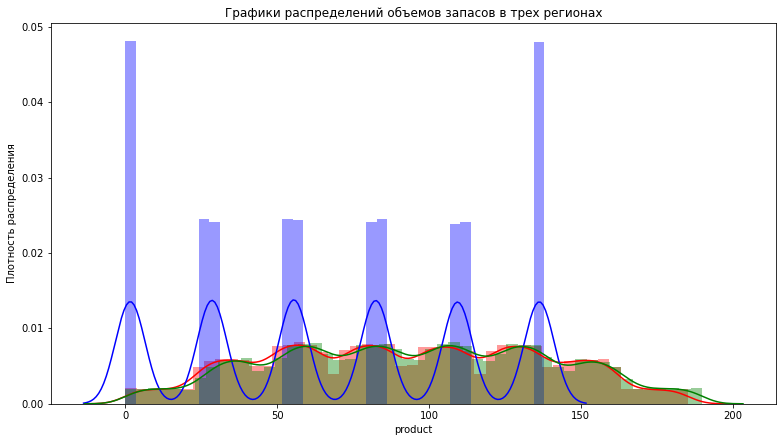

In [22]:
plt.figure(figsize = (13,7))
plt.title("Графики распределений объемов запасов в трех регионах")
plt.xlabel("тыс.баррелей")
plt.ylabel("Плотность распределения")

sns.distplot(df_0['product'], color="red");
sns.distplot(df_1['product'], color="blue");
sns.distplot(df_2['product'], color="green");

#plt.legend();

Распределения запасов в трех регионах очень отличается (особенно  выбивается второй регион, df_1). Поэтому целесоообразно строить отдельную модель для каждого региона.

# 2. Обучение и проверка модели

## 2.1.  Проверим признаки на мультиколлинеарность

Построим матрицу корреляций признаков и целевой переменной для каждого региона и визуализируем результаты с помощью тепловой карты.

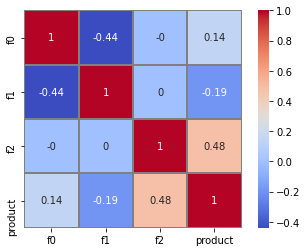

In [23]:
#поменять палитру можно с помощью параметра cmap= 'coolwarm'
sns.heatmap(df_0.corr().round(2), annot = True, square = True, linewidths=1, linecolor='gray', cmap= 'coolwarm'); 

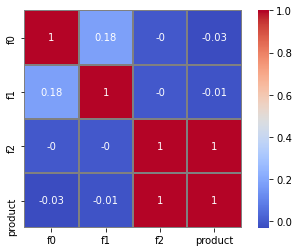

In [24]:
sns.heatmap(df_1.corr().round(2), annot = True, square = True, linewidths=1, linecolor='gray', cmap= 'coolwarm'); 

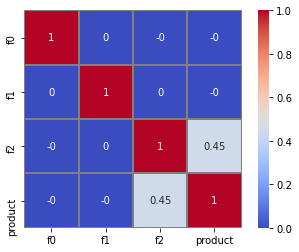

In [25]:
sns.heatmap(df_2.corr().round(2), annot = True, square = True, linewidths=1, linecolor='gray', cmap= 'coolwarm'); 

Глядя на тепловую карту и значения коэффициентов корреляции сразу видно, что представленные данные - полностью синтетические (в особенности это заметно по второму и третьему регионам) - слишком "круглые" значения коэффициентов.<br>


В датафрейме первого региона (df_0) мы имеем 2 признака, имеющих между собой заметную зависимость:f0 и f1 имеют коэффициент корреляции (-0,44). И хотя до "мультиколлинеарности" этих признаков еще далеко (обычно признаки считаются мультиколлинеарными при коэффициенте корреляции по модулю выше 0,8 - 0,9), все же лучше подстраховаться и для данного данных этого региона взять модель линейной регрессии с встроенной регуляризацей весов, например, Lasso() или Ridge(). Для данных остальных регионов можно брать обычную линейную регрессию.

## 2.2. Разделим данные на выборки, стандартизируем их

Выделим признаки и целевую переменную для каждого региона.

In [26]:
target_0 = df_0['product']
features_0 = df_0.drop('product', axis=1)

target_1 = df_1['product']
features_1 = df_1.drop('product', axis=1)

target_2 = df_2['product']
features_2 = df_2.drop('product', axis=1)

Поделим наш датасет на обучающую, валидационную и тестовую выборки в соотношении 60% / 20% / 20%. <br>

Зададим для удобства изменения некоторые гиперпараметры.

In [27]:
RS = 12345 # random_state

In [28]:
#поделим выборки на обучющую и валидационную  
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state = RS)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state = RS)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state = RS)

In [29]:
features_train_0.head(3)

,f0,f1,f2
27212,0.022450,0.951034,2.197333
7866,1.766731,0.007835,6.436602
62041,0.724514,0.666063,1.840177


Проверим размеры получившихся выборок по региону № 0:

In [30]:
print(features_train_0.shape)
print(features_valid_0.shape)
print(target_train_0.shape)
print(target_valid_0.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


Соотношение выборок верное.

Проведем стандартизацию признаков. Занесем названия численных признаков, подлежащих стандартизации (в данном случае это все три основных признака) в список. Это поможет нам после стандартизации получить признаки не в виде numpy darray, а в виде датафрейма, что удобнее для нас.

In [31]:
numeric = ['f0', 'f1', 'f2']

In [32]:
scaler = StandardScaler()

scaler.fit(features_train_0[numeric])
features_train_0[numeric] = scaler.transform(features_train_0[numeric])
features_valid_0[numeric] = scaler.transform(features_valid_0[numeric])

scaler.fit(features_train_1[numeric])
features_train_1[numeric] = scaler.transform(features_train_1[numeric])
features_valid_1[numeric] = scaler.transform(features_valid_1[numeric])

scaler.fit(features_train_2[numeric])
features_train_2[numeric] = scaler.transform(features_train_2[numeric])
features_valid_2[numeric] = scaler.transform(features_valid_2[numeric])

In [33]:
features_train_0.head(3)

,f0,f1,f2
27212,-0.544828,1.390264,-0.094959
7866,1.455912,-0.480422,1.209567
62041,0.260460,0.825069,-0.204865


In [34]:
target_train_0.head(3)

27212    147.370612
7866     147.630053
62041     77.696728
Name: product, dtype: float64

Cоздадим список, в котором будем фиксировать обозначение модели, результаты метрик, средний запас сырья по предсказанию модели.

In [35]:
results = []

## 2.3.0. Расчет для региона № 0

### Построим и обучим модель линейной регрессии, сделаем предсказания, выведем средние значения и метрики. Построим  baseline и сравним с ней результаты 

In [36]:
LinearRegression()

LinearRegression()

In [37]:
lr_0 = LinearRegression()
lr_0.fit(features_train_0, target_train_0)
predicted_valid_0 = lr_0.predict(features_valid_0)

mse = mean_squared_error(target_valid_0, predicted_valid_0)
mae = mean_absolute_error(target_valid_0, predicted_valid_0)
r2 = r2_score(target_valid_0, predicted_valid_0)

print("РЕГИОН № 0.    Linear Regression")
print('Средний запас предсказанного сырья в регионе 0: {:.2f}'.format(predicted_valid_0.mean()))
print('Средний реальный запас сырья в регионе 0: {:.2f}'.format(target_valid_0.mean()))
print("RMSE модели = {:.7f}".format(mse ** 0.5)) # np.sqrt(mse)
print("МАЕ модели = {:.7f}".format(mae))
print("R2-score модели = {:.7f}".format(r2))

#Сравним нашу модель со константной моделью, предсказыыающей среднее значение трейна (можно взять и медиану)
predicted_valid_const_0 = pd.Series(target_train_0.mean(), index = target_valid_0.index)
mse_const = mean_squared_error(target_valid_0, predicted_valid_const_0)
mae_const = mean_absolute_error(target_valid_0, predicted_valid_const_0)
r2_const = r2_score(target_valid_0, predicted_valid_const_0)
print()
print("Константная модель (Mean)")
print("RMSE конст. модели = {:.2f}".format(mse_const ** 0.5))
print("МАЕ конст. модели = {:.7f}".format(mae_const))
print("R2-score конст. модели = {:.7f}".format(r2_const))

РЕГИОН № 0.    Linear Regression
Средний запас предсказанного сырья в регионе 0: 92.59
Средний реальный запас сырья в регионе 0: 92.08
RMSE модели = 37.5794217
МАЕ модели = 30.9196008
R2-score модели = 0.2799432

Константная модель (Mean)
RMSE конст. модели = 44.29
МАЕ конст. модели = 37.6774351
R2-score конст. модели = -0.0001610


Наша модель предсказывает лучше константной: корень из средне-квадратичного отклонения и среднее абсолютное отклонение  меньше на 7 тыс.баррелей, чем у константной модели, и коэффициент детерминации также гораздо лучше (0.28 против 0).

До этого мы построили базовую модель вручную. Так же для определения baseline можно использовать  DummyRegressor() для задач регрессии (и DummyClassifier  для задач классификации).

In [38]:
DummyRegressor()

DummyRegressor()

In [39]:
# возьмем стратегию среднего (можем взять также медиану, квантиль или любую константу)
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(features_train_0, target_train_0)

print(dummy_regr.predict(features_train_0))

print(f'Коэффициент детерминации R2 базовой модели, предсказывающей среднее обучающей выборки: \
      {dummy_regr.score(features_train_0, target_train_0)}')

[92.64046775 92.64046775 92.64046775 ... 92.64046775 92.64046775
 92.64046775]
Коэффициент детерминации R2 базовой модели, предсказывающей среднее обучающей выборки:       0.0


Получили R2 равный нулю, что естественно вытекает из формулы расчета R2.


### Построим модель Ridge

Проверим, как работает модель линейной регресcии с встроенной L2-регуляризацией признаков (Ridge).

In [40]:
Ridge()

Ridge()

In [41]:
ridge_0 = Ridge(random_state = RS)
ridge_0.fit(features_train_0, target_train_0)
predicted_valid_0_ridge = ridge_0.predict(features_valid_0)
mse_ridge = mean_squared_error(target_valid_0, predicted_valid_0_ridge)

print("РЕГИОН № 0.   Ridge")
print('Средний запас предсказанного сырья в регионе 0: {:.2f}'.format(predicted_valid_0_ridge.mean()))
print('Средний реальный запас сырья в регионе 0: {:.2f}'.format(target_valid_0.mean()))
print("RMSE = {:.2f}".format(mse_ridge ** 0.5))
print()
print('Разница между моделями Linear Regression и Ridge:')
print('Дельта в RMSE = {:.2f}'.format((mse_ridge - mse) ** 0.5))

РЕГИОН № 0.   Ridge
Средний запас предсказанного сырья в регионе 0: 92.59
Средний реальный запас сырья в регионе 0: 92.08
RMSE = 37.58

Разница между моделями Linear Regression и Ridge:
Дельта в RMSE = 0.01


Получили, что модель Ridge предсказывает также, как и обычная линейная регрессия (RMSE практически одинаков). Поэтому оставим и для этого (нулевого) региона  модель линейной регрессии (для остальных двух регионов Ridge не нужен, так как признаки так совсем не мультиколлинеарны).

### Сохраним предсказания и правильные ответы на валидационной выборке

Сохраняем наши предсказания не в виде массива array, а  в виде Series с индексами как у target_valid, чтобы было соответствие индексов предсказаний и реальных значений. Или даже лучше сразу сохраним их в DataFrame, куда добавим реальные значения

In [42]:
predicted_valid_0

array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
       118.18039721, 118.16939229])

In [43]:
#predictions_0 = pd.Series(predicted_valid_0, index = target_valid_0.index)
#predictions_0

In [44]:
region_0 = pd.DataFrame(predicted_valid_0, index = target_valid_0.index, columns = ['predicted'])
region_0.head()

,predicted
71751,95.894952
80493,77.572583
2655,77.892640
53233,90.175134
91141,70.510088


Проверим, что индексы получились у 'target_valid_0' одинаковыми с 'predicted_valid_0' :

In [45]:
pd.DataFrame(target_valid_0).head()

,product
71751,10.038645
80493,114.551489
2655,132.603635
53233,169.072125
91141,122.325180


Добавляем в результат к предсказанным значениям также и реальные значения запасов, и также номер региона.

In [46]:
region_0['product'] = target_valid_0
region_0['region'] = 0
region_0.head()

,predicted,product,region
71751,95.894952,10.038645,0
80493,77.572583,114.551489,0
2655,77.892640,132.603635,0
53233,90.175134,169.072125,0
91141,70.510088,122.325180,0


Визуализируем график с сотами, чтобы посмотреть пересечения между предсказаниями и правильными ответами.

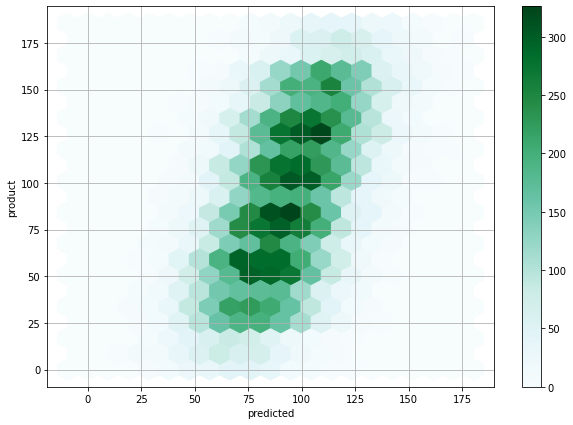

In [47]:
region_0.plot(x = 'predicted', y = 'product', kind='hexbin', gridsize=20, figsize=(10,7), sharex=False, grid=True);

Начнем заполнять список с результатами моделирования. Добавим результаты по региону №0.

In [48]:
# здесь заполняем списком, но можно заполнять и кортежами, как будет далее, в регионе 1 и 2. 
#DF потом можно будет создать и из списков , и из кортежей, причем можно смешивать, как сделано здесь
results.append(['lr_0', r2, mse ** 0.5, mae,  region_0['predicted'].mean(), lr_0])
results

[['lr_0',
  0.27994321524487775,
  37.57942171508131,
  30.919600777151313,
  92.59256778438008,
  LinearRegression()]]

## 2.3.1.  Расчет для региона № 1

### Проверим размеры получившихся выборок по региону № 1:

In [49]:
print(features_train_1.shape)
print(features_valid_1.shape)
print(target_train_1.shape)
print(target_valid_1.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [50]:
features_train_1.head(3)

,f0,f1,f2
27212,-0.850855,0.624428,0.296943
7866,1.971935,1.832275,0.294333
62041,1.079305,0.170127,-0.296418


In [51]:
target_train_1.head(3)

27212    84.038886
7866     80.859783
62041    53.906522
Name: product, dtype: float64

Стандартизировали признаки мы ранее.

### Построим и обучим модель линейной регрессии, сделаем предсказания, выведем средние значения и метрики. Построим  baseline и сравним с ней результаты 

In [52]:
lr_1 = LinearRegression()
lr_1.fit(features_train_1, target_train_1)
predicted_valid_1 = lr_1.predict(features_valid_1)

mse = mean_squared_error(target_valid_1, predicted_valid_1)
mae = mean_absolute_error(target_valid_1, predicted_valid_1)
r2 = r2_score(target_valid_1, predicted_valid_1)

print("РЕГИОН № 1.   Linear Regression")
print('Средний запас предсказанного сырья в регионе №1: {:.2f}'.format(predicted_valid_1.mean()))
print('Средний реальный запас сырья в регионе №1: {:.2f}'.format(target_valid_1.mean()))
print("RMSE модели = {:.7f}".format(mse ** 0.5)) # np.sqrt(mse)
print("МАЕ модели = {:.7f}".format(mae))
print("R2-score модели = {:.7f}".format(r2))

#Сравним нашу модель со константной моделью, предсказыыающей среднее значение трейна (можно взять и медиану)
predicted_valid_const_1 = pd.Series(target_train_1.mean(), index = target_valid_1.index)
mse_const = mean_squared_error(target_valid_1, predicted_valid_const_1)
mae_const = mean_absolute_error(target_valid_1, predicted_valid_const_1)
r2_const = r2_score(target_valid_1, predicted_valid_const_1)
print()
print("Константная модель (Mean)")
print("RMSE конст. модели = {:.2f}".format(mse_const ** 0.5))
print("МАЕ конст. модели = {:.7f}".format(mae_const))
print("R2-score конст. модели = {:.7f}".format(r2_const))

РЕГИОН № 1.   Linear Regression
Средний запас предсказанного сырья в регионе №1: 68.73
Средний реальный запас сырья в регионе №1: 68.72
RMSE модели = 0.8930993
МАЕ модели = 0.7187662
R2-score модели = 0.9996234

Константная модель (Mean)
RMSE конст. модели = 46.02
МАЕ конст. модели = 40.3700266
R2-score конст. модели = -0.0000087


Наша модель бесспорно предсказывает лучше константной: корень из средне-квадратичного отклонения и среднее абсолютное отклонение  очень малы (менее 1 тыс.баррелей) и коэффициент детерминации практически единица (против нуля у baseline). Столь хорошие показатели модели даже вызывают некоторые подозрения.

Здесь также стоит отметить, что ранее мы построили тепловую карту, и для данного региона замечена 100%-ная взаимосвязь признака 'f2' и целевой переменной (у них коэффициент корреляции Пирсона = 1). То есть по признаку 'f2' однозначно можно предсказать объем запасов скважины. В принципе, для данной конкретной модели (по данному региону) мы можем даже удалить остальные признаки ('f0' и 'f1'), которые создают шумы, и метрики должны еще больше улучшиться.

### Сохраним предсказания и правильные ответы на валидационной выборке

Сохраняем наши предсказания по региону № 1  в DataFrame, куда добавим реальные значения запасов и номер региона.

In [53]:
predicted_valid_1

array([ 82.66331365,  54.43178616,  29.74875995, ..., 137.87934053,
        83.76196568,  53.95846638])

In [54]:
region_1 = pd.DataFrame(predicted_valid_1, index = target_valid_1.index, columns = ['predicted'])
region_1['product'] = target_valid_1
region_1['region'] = 1
region_1.head()

,predicted,product,region
71751,82.663314,80.859783,1
80493,54.431786,53.906522,1
2655,29.748760,30.132364,1
53233,53.552133,53.906522,1
91141,1.243856,0.000000,1


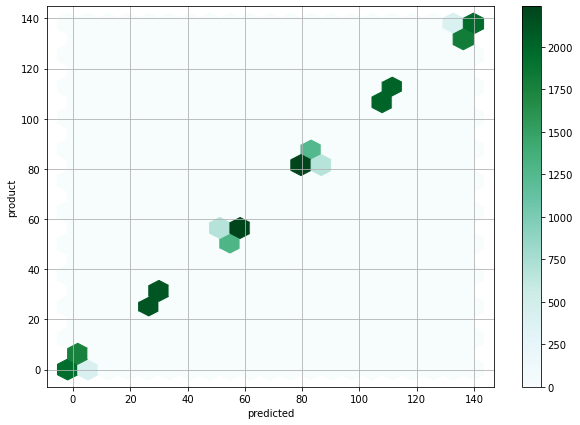

In [55]:
region_1.plot(x = 'predicted', y = 'product', kind='hexbin', gridsize=20, figsize=(10, 7), sharex=False, grid=True);

Дополним список с результатами полученными данными по региону № 1:

In [56]:
results.append(('lr_1', r2, mse ** 0.5, mae,  region_1['predicted'].mean(), lr_1))
results

[['lr_0',
  0.27994321524487775,
  37.57942171508131,
  30.919600777151313,
  92.59256778438008,
  LinearRegression()],
 ('lr_1',
  0.9996233978805127,
  0.893099286775618,
  0.7187662442124757,
  68.72854689544583,
  LinearRegression())]

## 2.3.2.   Расчет для региона № 2

### Проверим размеры получившихся выборок по региону № 2:

In [57]:
print(features_train_2.shape)
print(features_valid_2.shape)
print(target_train_2.shape)
print(target_valid_2.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)


In [58]:
features_train_2.head(3)

,f0,f1,f2
27212,-0.526160,0.776329,-0.400793
7866,-0.889625,-0.404070,-1.222936
62041,-1.133984,0.208576,0.296765


In [59]:
target_train_2.head(3)

27212     16.733577
7866      38.047492
62041    116.149369
Name: product, dtype: float64

Стандартизировали признаки мы ранее.

### Построим и обучим модель линейной регрессии, сделаем предсказания, выведем средние значения и метрики. Построим  baseline и сравним с ней результаты 

In [60]:
lr_2 = LinearRegression()
lr_2.fit(features_train_2, target_train_2)
predicted_valid_2 = lr_2.predict(features_valid_2)

mse = mean_squared_error(target_valid_2, predicted_valid_2)
mae = mean_absolute_error(target_valid_2, predicted_valid_2)
r2 = r2_score(target_valid_2, predicted_valid_2)

print("РЕГИОН № 2.   Linear Regression")
print('Средний запас предсказанного сырья в регионе №2: {:.2f}'.format(predicted_valid_2.mean()))
print('Средний реальный запас сырья в регионе №2: {:.2f}'.format(target_valid_2.mean()))
print("RMSE модели = {:.7f}".format(np.sqrt(mse))) 
print("МАЕ модели = {:.7f}".format(mae))
print("R2-score модели = {:.7f}".format(r2))

#Сравним нашу модель со константной моделью, предсказыыающей среднее значение трейна (можно взять и медиану)
predicted_valid_const_2 = pd.Series(target_train_2.mean(), index = target_valid_2.index)
mse_const = mean_squared_error(target_valid_2, predicted_valid_const_2)
mae_const = mean_absolute_error(target_valid_2, predicted_valid_const_2)
r2_const = r2_score(target_valid_2, predicted_valid_const_2)
print()
print("Константная модель (Mean)")
print("RMSE конст. модели = {:.2f}".format(mse_const ** 0.5))
print("МАЕ конст. модели = {:.7f}".format(mae_const))
print("R2-score конст. модели = {:.7f}".format(r2_const))

РЕГИОН № 2.   Linear Regression
Средний запас предсказанного сырья в регионе №2: 94.97
Средний реальный запас сырья в регионе №2: 94.88
RMSE модели = 40.0297087
МАЕ модели = 32.7926521
R2-score модели = 0.2052476

Константная модель (Mean)
RMSE конст. модели = 44.90
МАЕ конст. модели = 37.9210083
R2-score конст. модели = -0.0000118


Наша модель предсказывает лучше константной: корень из средне-квадратичного отклонения и среднее абсолютное отклонение  меньше примерно на 5 тыс.баррелей, чем у константной модели, и коэффициент детерминации также гораздо лучше (0.21 против 0).

Здесь также стоит отметить, что ранее мы построили тепловую карту, и для данного региона замечена 100%-ная взаимосвязь признака 'f2' и целевой переменной (у них коэффициент корреляции Пирсона = 1). То есть по признаку 'f2' однозначно можно предсказать объем запасов скважины. В принципе, для данной конкретной модели (по данному региону) мы можем удалить остальные признаки ('f0' и 'f1'), которые создают шумы, и метрики должны еще больше улучшиться.

### Сохраним предсказания и правильные ответы на валидационной выборке

Сохраняем наши предсказания по региону № 2  в DataFrame, куда добавим реальные значения запасов и номер региона.

In [61]:
predicted_valid_2

array([ 93.59963303,  75.10515854,  90.06680936, ...,  99.40728116,
        77.77991248, 129.03241718])

In [62]:
region_2 = pd.DataFrame(predicted_valid_2, index = target_valid_2.index, columns = ['predicted'])
region_2['product'] = target_valid_2
region_2['region'] = 2
region_2.head()

,predicted,product,region
71751,93.599633,61.212375,2
80493,75.105159,41.850118,2
2655,90.066809,57.776581,2
53233,105.162375,100.053761,2
91141,115.303310,109.897122,2


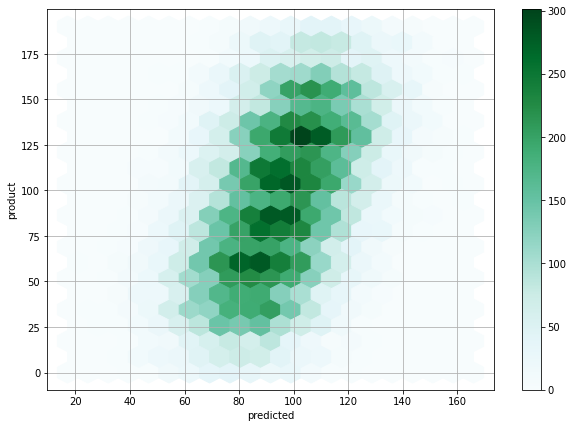

In [63]:
region_2.plot(x = 'predicted', y = 'product', kind='hexbin', gridsize=20, figsize=(10, 7), sharex=False, grid=True);

Дополним список с результатами полученными данными по региону № 2:

In [64]:
results.append(('lr_2', r2, mse ** 0.5, mae,  region_2['predicted'].mean(), lr_2))
results

[['lr_0',
  0.27994321524487775,
  37.57942171508131,
  30.919600777151313,
  92.59256778438008,
  LinearRegression()],
 ('lr_1',
  0.9996233978805127,
  0.893099286775618,
  0.7187662442124757,
  68.72854689544583,
  LinearRegression()),
 ('lr_2',
  0.20524758386040465,
  40.02970873393434,
  32.79265210548181,
  94.96504596800509,
  LinearRegression())]

## 2.4  Выведем все результаты по всем трем регионам в одном датафрейме.

In [65]:
results_df = pd.DataFrame(results, columns=['model', 'r2', 'rmse', 'mae', 'predicted_mean_product', 'params'])
results_df

,model,r2,rmse,mae,predicted_mean_product,params
0,lr_0,0.279943,37.579422,30.919601,92.592568,LinearRegression()
1,lr_1,0.999623,0.893099,0.718766,68.728547,LinearRegression()
2,lr_2,0.205248,40.029709,32.792652,94.965046,LinearRegression()


In [66]:
results_df[['model', 'r2', 'rmse', 'mae', 'predicted_mean_product']].style.highlight_min(color='lightblue', axis = 0)

,model,r2,rmse,mae,predicted_mean_product
0,lr_0,0.279943,37.579422,30.919601,92.592568
1,lr_1,0.999623,0.893099,0.718766,68.728547
2,lr_2,0.205248,40.029709,32.792652,94.965046


**По всем трем регионам построили модели линейной регрессии со следующими метриками RMSE:**
- регион №0:  37.58,
- регион №1:  0.89,
- регион №2:  40.03.
**Наилучшие метрики имеет модель по региону № 1, однако целевая переменная этой модели имеет очень странное распределение: 6 значений через большие промежутки.**



## 2.5  Сравним средние значения предсказанных и реальных запасов

In [67]:
region_report = pd.concat([region_0, region_1, region_2])
region_report

,predicted,product,region
71751,95.894952,10.038645,0
80493,77.572583,114.551489,0
2655,77.892640,132.603635,0
53233,90.175134,169.072125,0
91141,70.510088,122.325180,0
...,...,...,...
12581,78.765887,28.492402,2
18456,95.603394,21.431303,2
73035,99.407281,125.487229,2
63834,77.779912,99.422903,2


In [68]:
region_report.pivot_table(index='region')

,predicted,product
region,,
0,92.592568,92.078597
1,68.728547,68.723136
2,94.965046,94.884233


**Средние предсказанных запасов очень близки к средним реальных запасов.**<br>
**При этом средние значения запасов в регионах гораздо меньше рассчитанного среднего в 112 тыс.баррелей, необходимого для безубыточной разработки новых месторождений.** Поэтому мы будем отбирать для разработки только самые перспективные скважины.

# 3. Подготовка к расчёту прибыли

### 3.1 Расчет и сохранение ключевых значений

Сохраним все ключевые значения для расчетов в отдельных переменных. Посчитаем недостающие значения.

Общий бюджет на разработку месторождений в регионе - 10 млрд. рублей

In [69]:
BUDGET = 10000000000

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения будут выбирать 200 лучших для разработки. То есть в итоге разрабатываться будут только 200 скважин.

In [70]:
WELLS_COUNT = 200

Посчитаем стоимость разработки одной скважины:

In [71]:
PRICE_PER_WELL = BUDGET / WELLS_COUNT
PRICE_PER_WELL

50000000.0

Получили стоимость разработки одной скважины - 50 млн. руб.

Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём  запасов (product) в скважине указан в тысячах баррелей.<br>
Доход с единицы продукта:

In [72]:
INCOME_PER_THOUSAND_BARRELS = 450*1000
INCOME_PER_THOUSAND_BARRELS

450000

### 3.2 Расчет минимального  объёма сырья (в среднем), достаточного для безубыточной разработки новой скважины

Для того, чтобы найти минимально-необходимое количество сырья в скважине (в среднем по всем 200 скважинам), достаточное лдя бузубыточной разработки скважины, поделим стоимость разработки одной скважины на доход с одной единицы продукции, и округлим полученное значение вверх.

In [73]:
minimum_mean_product = np.ceil(PRICE_PER_WELL / INCOME_PER_THOUSAND_BARRELS)
minimum_mean_product

112.0

**112 единиц продукции (то есть тысяч баррелей) должен быть минимальный запас в разрабатываемой скважине (в среднем) для ее безубыточности**.<br> Если мы еще раз посмотрим на описательные статистики и графики распределений целевой переменной, то увидим, что по регионам №0 и №2 более 25% от всех данных (а, значит, и от валидационной выборки) значения целевой переменной заведомо превышают это значение (75-я процентиль - 128 и  130 единиц соответственно). В регионе №1    85-я процентиль - 134 единиц. Значит, минимум 3750 скважин (15% * 25000 скважин) валидационной выборки любого региона удовлетворяют этому условию, а это заведомо больше 200 скважин по условию проекта. То есть нам будет из чего отобрать безубыточные скважины для разработки.

# 4. Расчёт прибыли и рисков 

### 4.1 Функция расчета прибыли

Напишем функцию для расчёта прибыли по набору отобранных месторождений на основании предсказаний модели.

In [74]:
def profit_calculation(target, predictions, number_of_wells):
    ''' Функция принимает на вход:
    - predictions - набор из 500 (или любого кол-ва, но не менее 200) случайно отобранных предсказаний 
                из валидационной выборки (тип данных Series),
    - target - набор соответствующих им реальных значений запасов из валид. выборки (тип данных Series),
    - максимальное количество скважин к разработке (200) (тип данных int).
    Сортирует объем предсказанных запасов по убыванию.  
    Возвращает значение прибыли от разработки в регионе, посчитанное по реальным запасам скважин.
    '''
    best_predictions = predictions.sort_values(ascending = False)[:number_of_wells]
    best_target = target[best_predictions.index]
    profit = best_target.sum()*INCOME_PER_THOUSAND_BARRELS - BUDGET
    return profit

### 4.2  Функция для бутстрепа

Напишем функцию для применения техники Bootstrap с 1000 подвыборок из валидационной выборки по 500 скважин в каждой, чтобы найти распределение прибыли.

При создании подвыборок при обычной фиксации параметра random_state (в виде random_state = 12345) выбранные случайные элементы всегда одинаковые. Чтобы это исправить, создадим объект RandomState() из модуля numpy.random.

Этот объект можно передавать аргументу random_state в любой функции. Важно, что при каждом новом вызове его состояние будет меняться на случайное. Так получаем разные подвыборки. И при этом при перезапуске ноутбука (ядра) данная "последовательность cлучайностей" будет повторяться. Так мы обеспечим воспроизводимость результатов эксперимента.<br>
    Так же для того, чтобы мы каждый раз при создании подвыборок делали выбор из одной и той же исходной валидационной выборки в 25000 наблюдений, необходимо обеспечить выбор элементов с возвращением. То есть один и тот же элемент может попадать в подвыборку несколько раз. Для этого укажем аргумент replace=True в функции sample().

In [75]:
state = RandomState(12345) 
    
def bootstrap(target, predictions,  N):
    '''
    Функция применяет технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    Принимает на вход:
    - набор предсказаний (predictions), сделанных на валидационной выборке (в нашем случае 25000), тип данных Series,
    - набор соответствующих им реальных значений запасов (target) валид. выборки (25000 набл.), тип данных Series,
    - количество выбираемых случайных образом скважин (в нашем случае 500 по условию задачи), тип данных int.
                                                       
    1000 раз из 25000 случайным образом выбирает 500 скважин. С помощью функции profit_calculation считаем по лучшим 
    200 из них прибыль. И так 1000 раз.
    Возвращает набор (Series) из 1000 значений прибыли, посчитанной по лучшим 200 скважинам, отобранным из 500. 
    '''
    profit_list = []
    
    for i in range(1000):
        pred_subsample = predictions.sample(n = N, replace = True, random_state = state)
        targ_subsample = target[pred_subsample.index]
        profit_subsample = profit_calculation(targ_subsample, pred_subsample, WELLS_COUNT)
        profit_list.append(profit_subsample)
    
    profit = pd.Series(profit_list)
    
    return profit

Cоздадим список, в котором будем фиксировать результаты: номер региона, среднее значение прибыли для региона, 0.025-я квантиль, доверительный интервал и риск убытков.

In [76]:
profit_report = []

### 4.3   Рассчитаем среднюю прибыль и риски убытков по региону №0.

In [77]:
profit_bootstrap_region_0 = bootstrap(region_0['product'], region_0['predicted'], 500)
profit_bootstrap_region_0 #полученная бутстрепом выборка из прибыли

0      9.886908e+08
1      5.363934e+08
2      6.336436e+08
3      5.896001e+08
4      2.719929e+08
           ...     
995    5.566130e+08
996    9.280870e+08
997    1.030250e+09
998    5.354841e+08
999    5.015203e+08
Length: 1000, dtype: float64

In [78]:
mean_profit_region_0 = round( profit_bootstrap_region_0.mean()/10**6, 2)   #средняя прибыль по региону №0
lower_0 = round( profit_bootstrap_region_0.quantile(0.025)/10**6  , 2)  # нижняя граница доверительного интервала
upper_0 = round( profit_bootstrap_region_0.quantile(0.975)/10**6 , 2)    # верхняя граница доверительного интервала

print("Средняя прибыль для региона №2 (в млн.руб.): ", mean_profit_region_0)
print('0.025-я квантиль прибыли региона №2 (млн.руб.): ', lower_0)
print('Доверительный интервал (млн.руб.): (',lower_0, ';', upper_0, ')')

Средняя прибыль для региона №2 (в млн.руб.):  600.74
0.025-я квантиль прибыли региона №2 (млн.руб.):  12.95
Доверительный интервал (млн.руб.): ( 12.95 ; 1231.16 )


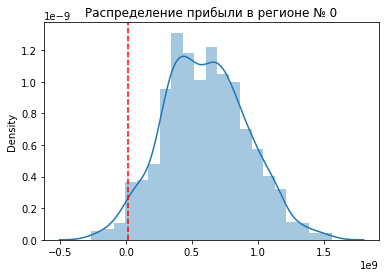

In [79]:
ax = sns.distplot(profit_bootstrap_region_0);
ax.axvline(np.quantile(profit_bootstrap_region_0, 0.025),linestyle = '--',color='r');
plt.title("Распределение прибыли в регионе № 0");

Чтобы посчитать риск убытков, найдем в нашей полученной бутстрепом выборке долю убытков (отрицательных значений прибыли) в общем количестве прибыли.

In [80]:
loss_risk_0 = profit_bootstrap_region_0[profit_bootstrap_region_0 < 0].count()/profit_bootstrap_region_0.count()
loss_risk_0

0.02

Занесем данные по региону № 0 в наш отчетный список.

In [81]:
profit_report.append(['region_0', mean_profit_region_0, lower_0, 
                      (lower_0, upper_0), loss_risk_0])
profit_report

[['region_0', 600.74, 12.95, (12.95, 1231.16), 0.02]]

### 4.4  Рассчитаем среднюю прибыль и риски убытков по региону №1.

In [82]:
profit_bootstrap_region_1 = bootstrap(region_1['product'], region_1['predicted'], 500)
profit_bootstrap_region_1 #полученная бутстрепом выборка из прибыли

0      5.419387e+08
1      2.008970e+08
2      1.295538e+08
3      5.862250e+08
4      5.512065e+08
           ...     
995    5.805026e+08
996    6.053826e+08
997    5.447999e+08
998    1.218984e+09
999    3.971375e+08
Length: 1000, dtype: float64

In [83]:
mean_profit_region_1 = round( profit_bootstrap_region_1.mean()/10**6, 2)   #средняя прибыль по региону №1
lower_1 = round( profit_bootstrap_region_1.quantile(0.025)/10**6  , 2)  # нижняя граница доверительного интервала
upper_1 = round( profit_bootstrap_region_1.quantile(0.975)/10**6 , 2)    # верхняя граница доверительного интервала

print("Средняя прибыль для региона №2 (в млн.руб.): ", mean_profit_region_1)
print('0.025-я квантиль прибыли региона №2 (млн.руб.): ', lower_1)
print('Доверительный интервал (млн.руб.): (',lower_1, ';', upper_1, ')')

Средняя прибыль для региона №2 (в млн.руб.):  663.96
0.025-я квантиль прибыли региона №2 (млн.руб.):  206.48
Доверительный интервал (млн.руб.): ( 206.48 ; 1191.2 )


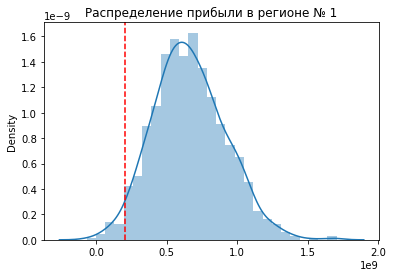

In [84]:
ax = sns.distplot(profit_bootstrap_region_1);
ax.axvline(np.quantile(profit_bootstrap_region_1, 0.025),linestyle = '--',color='r');
plt.title("Распределение прибыли в регионе № 1");

Посчитаем риск убытков по региону №1.

In [85]:
loss_risk_1 = profit_bootstrap_region_1[profit_bootstrap_region_1 < 0].count() / profit_bootstrap_region_1.count()
loss_risk_1

0.001

Дополним отчетный список данными  по региону № 1.

In [86]:
profit_report.append(['region_1', mean_profit_region_1, lower_1, 
                      (lower_1, upper_1), loss_risk_1])
profit_report

[['region_0', 600.74, 12.95, (12.95, 1231.16), 0.02],
 ['region_1', 663.96, 206.48, (206.48, 1191.2), 0.001]]

### 4.5  Рассчитаем среднюю прибыль и риски убытков по региону №2.

In [87]:
profit_bootstrap_region_2 = bootstrap(region_2['product'], region_2['predicted'], 500)
profit_bootstrap_region_2 #полученная бутстрепом выборка из прибыли

0      8.627840e+08
1      7.651569e+08
2      3.418420e+08
3      6.876462e+08
4      6.528601e+08
           ...     
995    5.793411e+08
996    3.741776e+08
997    5.385141e+08
998    9.475967e+08
999    6.003961e+07
Length: 1000, dtype: float64

In [88]:
mean_profit_region_2 = round( profit_bootstrap_region_2.mean()/10**6, 2)   #средняя прибыль по региону №2
lower_2 = round( profit_bootstrap_region_2.quantile(0.025)/10**6  , 2)  # нижняя граница доверительного интервала
upper_2 = round( profit_bootstrap_region_2.quantile(0.975)/10**6 , 2)    # верхняя граница доверительного интервала

print("Средняя прибыль для региона №2 (в млн.руб.): ", mean_profit_region_2)
print('0.025-я квантиль прибыли региона №2 (млн.руб.): ', lower_2)
print('Доверительный интервал (млн.руб.): (',lower_2, ';', upper_2, ')')

Средняя прибыль для региона №2 (в млн.руб.):  597.38
0.025-я квантиль прибыли региона №2 (млн.руб.):  1.73
Доверительный интервал (млн.руб.): ( 1.73 ; 1246.22 )


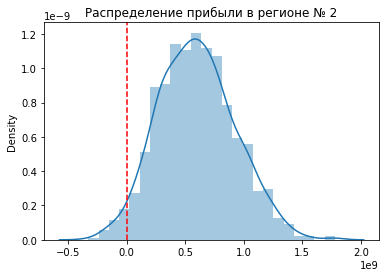

In [89]:
ax = sns.distplot(profit_bootstrap_region_2);
ax.axvline(np.quantile(profit_bootstrap_region_2, 0.025),linestyle = '--',color='r');
plt.title("Распределение прибыли в регионе № 2");

Посчитаем риск убытков по региону №2.

In [90]:
loss_risk_2 = profit_bootstrap_region_2[profit_bootstrap_region_2 < 0].count() / profit_bootstrap_region_2.count()
loss_risk_2

0.025

Дополним отчет данными  по региону № 2.

In [91]:
profit_report.append(['region_2', mean_profit_region_2, lower_2, 
                      (lower_2, upper_2), loss_risk_2])
profit_report

[['region_0', 600.74, 12.95, (12.95, 1231.16), 0.02],
 ['region_1', 663.96, 206.48, (206.48, 1191.2), 0.001],
 ['region_2', 597.38, 1.73, (1.73, 1246.22), 0.025]]

# 5. Анализ результатов. Выбор региона для разработки

Распределение прибыли по всем трем регионам - нормальное или близко к нормальному. В принципе, при таком колоколо-образном распределении, как у регионов № 1 и №2 для поиска доверительного интервала можно было мы использовать функцию st.t.interval их библиотеки scipy, но поскольку распределение прибыли для первого региона не идеально похоже на нормальное, мы решили использовать квантили для определения доверительного интервала всех трех регионов.

Выведем сводную информацию результатов по трем регионам.

In [92]:
profit_report_df = pd.DataFrame(profit_report, columns=['region', 'mean_revenue', '2.5%-quantile', '95%_conf_int', 'loss_risk'])
profit_report_df.style.highlight_max(color='lightblue', axis = 0)

,region,mean_revenue,2.5%-quantile,95%_conf_int,loss_risk
0,region_0,600.740000,12.950000,"(12.95, 1231.16)",0.020000
1,region_1,663.960000,206.480000,"(206.48, 1191.2)",0.001000
2,region_2,597.380000,1.730000,"(1.73, 1246.22)",0.025000


Прежде всего напомним, что ранее мы отмечали синтетичность данных и странность распределений запасов нефти по регионам, в особенности для региона №1. Необходимо учитывать это при принятии решения на будущее.<br> 

Среднее значение прибыли по регионам колеблется в интервале от 597 до 664 млн.рублей: это не такой уж и большой разброс  средней прибыли (в пределах 10%). Однако 0.025-я квантиль уже имеет очень большой разброс: в регионе №1 - 206 млн.руб., а в регионе №2 - всего 1,7 млн.руб.  То есть распределение прибыли в регионе № 1  гораздо "кучнее" расположено вокруг среднего значения, чем у регионов №0 и №2 (это заметно и на графиках распределения), да и само среднее значение у региона №1 (664 млн. руб.) - выше, чем у остальных регионов.<br>
Аналогично обстоят дела и с риском убытков: у нулевого и второго регионов значения риска убытков близки (2 и 2,5%), а у региона №1 риск убытков минимален и составляет всего 0,1%.<br> 

**Следовательно, по совокупности факторов выигрывает регион № 1: с вероятностью 95% прибыль от разработки новых 200 скважин составит от 206,5 до 1191 млн.руб., ожидаемое (среднее) значение прибыли - 664 млн.руб., риск убытков - 0,1%.**<br>

**ТАКИМ ОБРАЗОМ, ПРЕДЛАГАЕМЫЙ К РАЗРАБОТКЕ НОВЫХ СКВАЖИН РЕГИОН - №1** (c учетом вышеизложенных оговорок).